# M2 DAC - 2023/2024 - AMAL PROJECT
# ICLR 2024 - Towards Batch Normalization Without Gradient Explosion
### Authors of paper : Alexandru METEREZ, Amir JOUDAKI, Francesco ORABONA, Alexander IMMER, Gunnar RATSCH, Hadi DANESHMAND

### Notebook by: Allaa BOUTALEB, Samy NEHLIL & Ghiles OUHENIA 

This notebook contains all the necessary code to reproduce the figures in the poster.

**Useful information**: 

- You can run each section in this notebook independently without having to run the rest.

- For each section in this notebook, **simply choose the dataset you want to use through the DATASET variable**, and run the rest automatically. The right transforms, input and output sizes will be applied based on the dataset. 

In [1]:
# Standard library imports
import itertools
import sys
sys.path.append("..")


# Third-party imports
import torch
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from torch import nn
from torchvision import datasets
from tqdm import tqdm
from torch.utils.data import DataLoader


# Local imports
from src.utils import isometry_gap
from src.model import MLPWithBatchNorm
from src.constants import *

# Plotting configurations
matplotlib.rcParams["figure.dpi"] = 80
sns.set(rc={"figure.dpi": 80, 'savefig.dpi': 80})
sns.set_theme()
sns.set_context('paper')
palette = sns.color_palette("tab10")


style = {"grid.linestyle": ":", 
        "border.color": "black",
       "axes.edgecolor": "black",
       "xtick.bottom": "True",
       "xtick.top": "True",
       "ytick.left": "True",
       "ytick.right": "True",
       "xtick.direction": "in",
       "ytick.direction": "in"}

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
figure_dir = 'Figures/'

# Useful information 

You can run each section in this notebook independently without having to run the rest.

For each section in this notebook, simply choose the dataset you want to use through the DATASET variable, and run the rest automatically. The right transforms, input and output sizes will be applied based on the dataset. 

# 1 - Isometry Gap

In [3]:
# Possible choices : ['MNIST', 'CIFAR10', 'CIFAR100', 'FashionMNIST']
DATASET = 'CIFAR10'

In [4]:
# Load dataset
root_dir = 'Data/'
train_set = getattr(datasets, DATASET)(root=root_dir, train=True, download=True, transform=DS_TRANSFORMS[DATASET])


Files already downloaded and verified


In [5]:
widths = [16, 32, 64, 128, 256, 512, 1024]
inits = ['orthogonal']
act_names = ['identity']
depths = [200]
runs = list(itertools.product(*[inits, act_names, depths, widths]))

## Isometry Gap with real data batches

In [6]:
# Initialize an empty list to store experiment results.
real_dataset_isogap = []

# Iterate over predefined configurations
for run in tqdm(runs, desc="Running experiments"):
    init_type, act_name, L, width = run  # Unpack configuration
    n = width  # Number of samples, set to dimension width

    # DataLoader setup for test data
    train_loader = DataLoader(train_set, batch_size=n, shuffle=True)
    test_x, test_y = next(iter(train_loader))
    test_x = test_x.to(device).flatten(1, -1)
    test_y = test_y.to(device)

    for _ in range(10):  # Repeat experiment 10 times for each config
        # Initialize model with the specified configuration
        activation = ACTIVATIONS[act_name]
        model = MLPWithBatchNorm(input_dim=DS_INPUT_SIZES[DATASET], 
                                 output_dim=DS_NUM_CLASSES[DATASET], 
                                 num_layers=L, 
                                 hidden_dim=width, 
                                 norm_type='bn',
                                 bias=False,
                                 order='norm_act',
                                 force_factor=1.0,
                                 mean_reduction=False,
                                 activation=activation,
                                 exponent=0,
                                 save_hidden=True).to(device)

        # Reset model parameters
        model.reset_parameters(init_type, gain=GAINS[act_name])

        # Forward pass and collect hidden states
        model.zero_grad()
        y_pred = model(test_x)
        outputs = model.hiddens

        # Analyze isometry gap across layers
        for layer_num in range(L):
            gap = isometry_gap(outputs[f'fc_{layer_num}']).item()  # Isometry gap for layer output

            # Append result
            real_dataset_isogap.append({
                'isogap': gap,
                'Activation': act_name,
                'Initialization': init_type,
                'Layer': layer_num,
                'width': width
            })

# Convert experiment results to a pandas DataFrame
real_dataset_isogap = pd.DataFrame(real_dataset_isogap)


Running experiments: 100%|██████████| 7/7 [01:31<00:00, 13.06s/it]


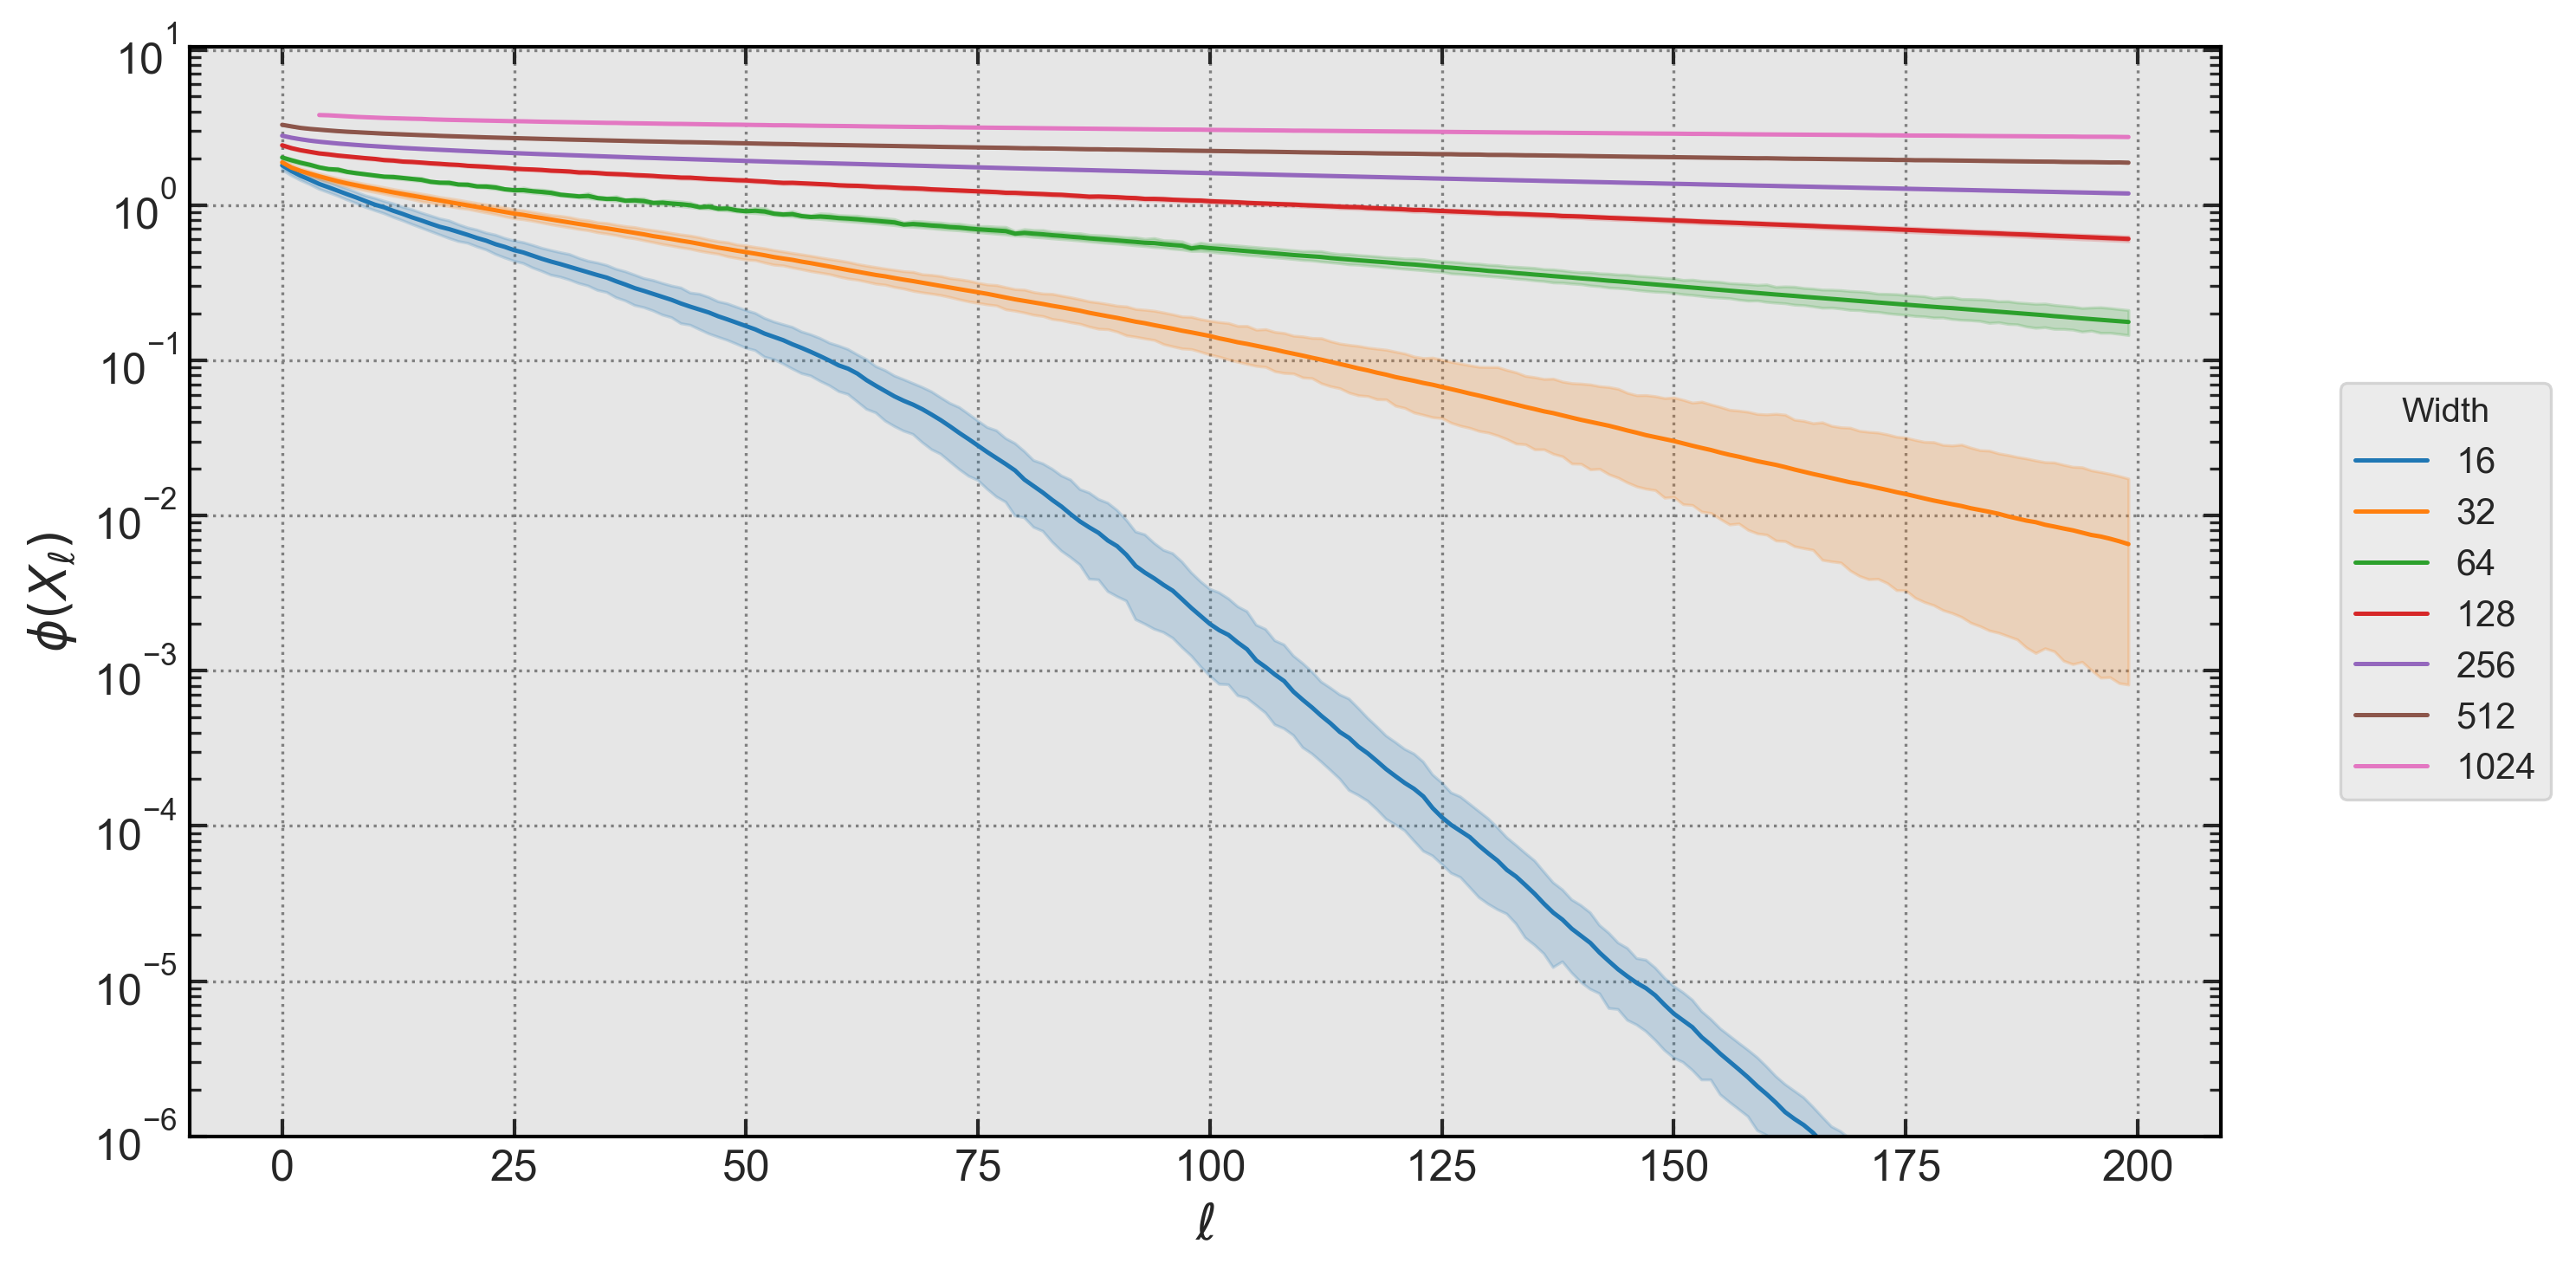

In [7]:
# Filter the DataFrame for 'identity' activation
edited_df = real_dataset_isogap[real_dataset_isogap['Activation'] == 'identity']

# Prepare the style settings
sns.set_style('darkgrid', {'axes.facecolor': '0.9', 'grid.color': '.5', **style})

# Create a figure for plotting
fig, ax = plt.subplots(dpi=300, figsize=(10, 5))

# Get unique 'd' values and create a palette dictionary
unique_width_values = sorted(edited_df['width'].unique())
palette_dict = {d: color for d, color in zip(unique_width_values, sns.color_palette("tab10", len(unique_width_values)))}

# Plotting loop for each 'width' value
for d_value in unique_width_values:
    subset_df = edited_df[edited_df['width'] == d_value]
    sns.lineplot(data=subset_df, x='Layer', y='isogap', ax=ax, color=palette_dict[d_value], label=f'{d_value}')

# Adjust the plot appearance and scale
ax.set_yscale('log')
ax.set_ylabel(r'$\phi(X_\ell)$', fontsize=14)
ax.set_xlabel(r'$\ell$', fontsize=14)
ax.set_ylim(bottom=1e-6)
ax.tick_params(axis='both', which='major', labelsize=12)

# Adjust legend to clearly differentiate width ('width' values)
ax.legend(title='Width', loc='center left', bbox_to_anchor=(1.05, 0.5), fontsize=10)

# Ensure the layout is tight so everything fits nicely
fig.tight_layout()

plt.savefig(figure_dir+'isogap_realdata.pdf')

# Display the plot
plt.show()


## Isometry gap using a perturbed identity matrix

In [8]:
# Initialize an empty list to store experiment results.
perturbed_ident_isogap = []

# Perturbation factor for generating the perturbed identity matrix.
f = 0.01

# Iterate over predefined configurations
for run in tqdm(runs, desc="Running experiments"):
    init_type, act_name, L, width = run  # Unpack configuration
    d = width  # Dimension of the square matrix

    # Generate a perturbed identity matrix as test input
    test_x = (1 - f) * torch.eye(d).to(device) + f * torch.rand(d, d).to(device)

    # Generate random test output labels
    test_y = torch.randint(low=0, high=d, size=(d,)).to(device)

    for _ in range(10):  # Repeat experiment 10 times for each config
        # Initialize model with the specified configuration
        activation = ACTIVATIONS[act_name]
        model = MLPWithBatchNorm(input_dim=d,  # Adjust input dimension to match the perturbed identity matrix
                                 output_dim=d, # Filler value, doesn't matter because we're not observing the model's output, just the isogap
                                 num_layers=L, 
                                 hidden_dim=width, 
                                 norm_type='bn',
                                 bias=False,
                                 order='norm_act',
                                 force_factor=1.0,
                                 mean_reduction=False,
                                 activation=activation,
                                 exponent=0,
                                 save_hidden=True).to(device)

        # Reset model parameters
        model.reset_parameters(init_type, gain=GAINS[act_name])

        # Forward pass and collect hidden states
        model.zero_grad()
        y_pred = model(test_x)
        outputs = model.hiddens

        # Analyze isometry gap across layers
        for layer_num in range(L):
            gap = isometry_gap(outputs[f'fc_{layer_num}']).item()  # Isometry gap for layer output

            # Append result
            perturbed_ident_isogap.append({
                'isogap': gap,
                'Activation': act_name,
                'Initialization': init_type,
                'Layer': layer_num,
                'width': width
            })

# Convert experiment results to a pandas DataFrame
perturbed_ident_isogap = pd.DataFrame(perturbed_ident_isogap)


Running experiments: 100%|██████████| 7/7 [01:26<00:00, 12.33s/it]


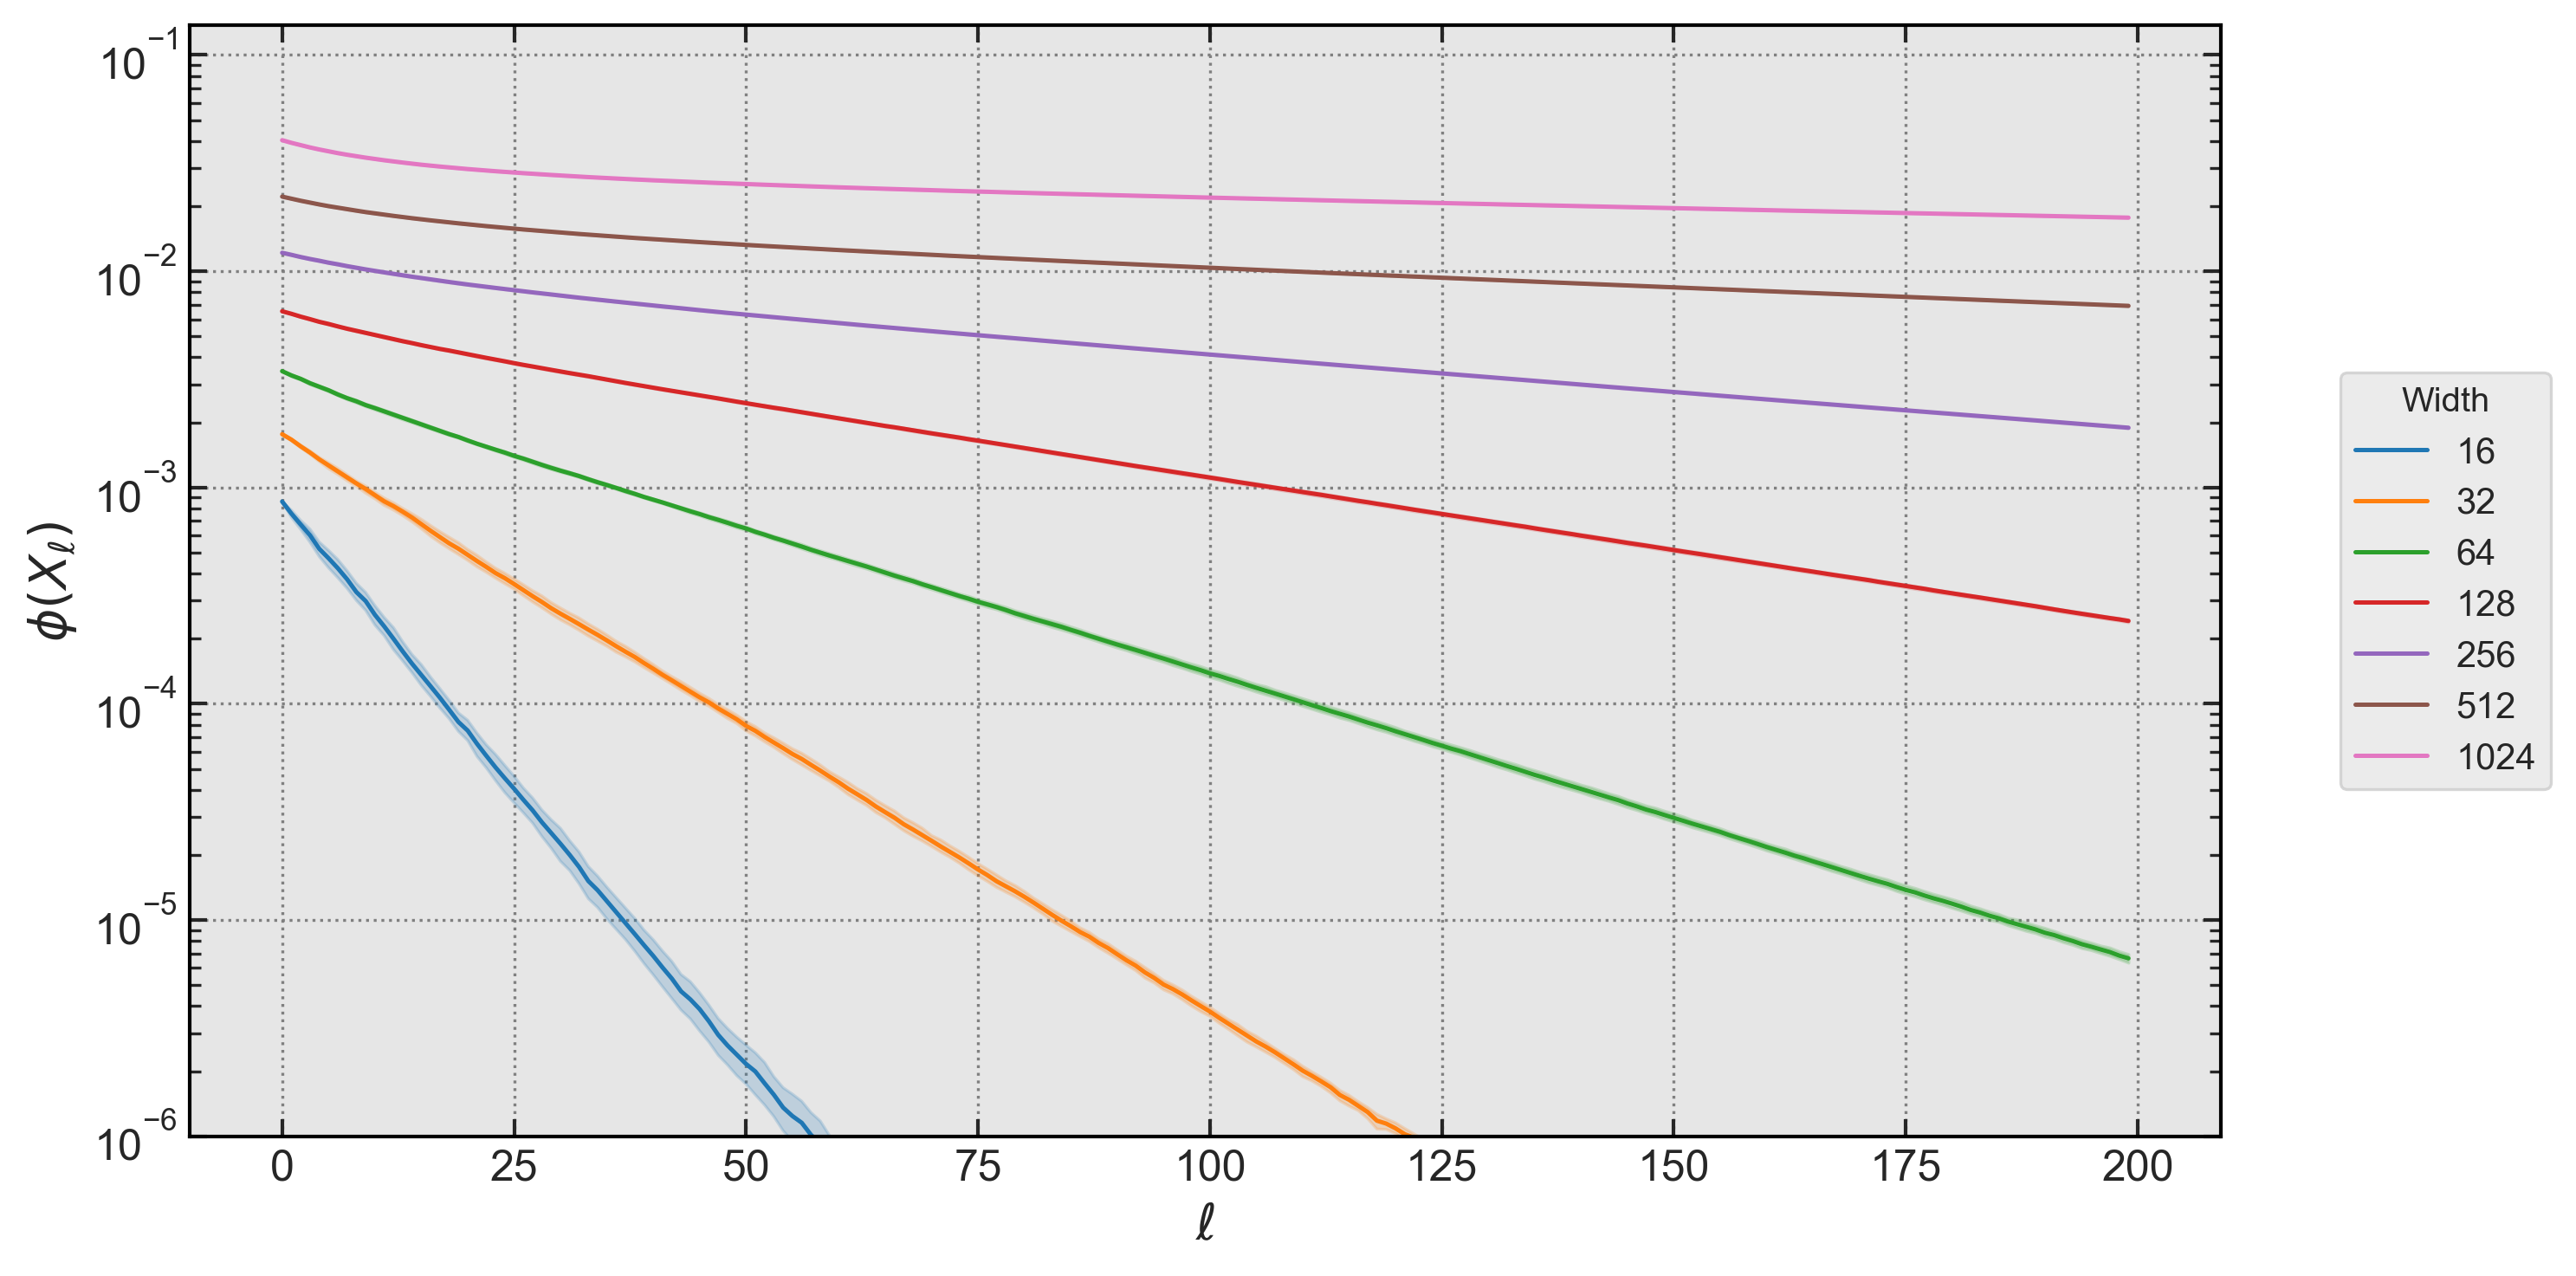

In [9]:
# Filter the DataFrame for 'identity' activation
edited_df = perturbed_ident_isogap[perturbed_ident_isogap['Activation'] == 'identity']

# Prepare the style settings
sns.set_style('darkgrid', {'axes.facecolor': '0.9', 'grid.color': '.5', **style})

# Create a figure for plotting
fig, ax = plt.subplots(dpi=300, figsize=(10, 5))

# Get unique 'd' values and create a palette dictionary
unique_width_values = sorted(edited_df['width'].unique())
palette_dict = {width: color for width, color in zip(unique_width_values, sns.color_palette("tab10", len(unique_width_values)))}

# Plotting loop for each 'd' value
for width in unique_width_values:
    subset_df = edited_df[edited_df['width'] == width]
    sns.lineplot(data=subset_df, x='Layer', y='isogap', ax=ax, color=palette_dict[width], label=f'{width}')

# Adjust the plot appearance and scale
ax.set_yscale('log')
ax.set_ylabel(r'$\phi(X_\ell)$', fontsize=14)
ax.set_xlabel(r'$\ell$', fontsize=14)
ax.set_ylim(bottom=1e-6)
ax.tick_params(axis='both', which='major', labelsize=12)

# Adjust legend to clearly differentiate width values
ax.legend(title='Width', loc='center left', bbox_to_anchor=(1.05, 0.5), fontsize=10)

# Ensure the layout is tight so everything fits nicely
fig.tight_layout()

plt.savefig(figure_dir+'isogap_syntheticdata.pdf')

# Display the plot
plt.show()


# 2 - Effect of Weight Initialization Type on Gradients

In [10]:
# Possible choices : ['MNIST', 'CIFAR10', 'CIFAR100', 'FashionMNIST']
DATASET = 'CIFAR10'

In [11]:
d = 100 # MLP WIDTH (HIDDEN LAYER SIZE)
n = 100 # BATCH SIZE

# Load dataset
root_dir = 'Data/'
train_set = getattr(datasets, DATASET)(root=root_dir, train=True, download=True, transform=DS_TRANSFORMS[DATASET])
train_loader = torch.utils.data.DataLoader(train_set, batch_size=n, shuffle=True)

# Prepare test data
test_x, test_y = next(iter(train_loader))
test_x = test_x.to(device).flatten(1, -1)
test_y = test_y.to(device)

Files already downloaded and verified


In [12]:
# Define experiment configurations
inits = ['orthogonal', 'xavier_normal']
act_names = ['identity', 'tanh', 'sin']
depths = [5, 10, 20, 50, 100, 250, 512, 1000]
runs = list(itertools.product(inits, act_names, depths))

In [13]:
# Initialize an empty list for storing experiment results
results = [] 


# Iterating over each configuration
for init_type, act_name, depth in tqdm(runs, desc="Experiment Progress"):
    for expi in range(10):  # Repeat experiment 10 times for statistical significance
        # Select activation function and determine exponent based on activation type
        activation = ACTIVATIONS[act_name]

        # Initialize the model with specified configuration
        model = MLPWithBatchNorm(input_dim=DS_INPUT_SIZES[DATASET],  # For CIFAR-10 dataset
                                 output_dim=DS_NUM_CLASSES[DATASET],  # Number of classes in CIFAR-10
                                 num_layers=depth, 
                                 hidden_dim=d, 
                                 norm_type='bn',
                                 bias=False,
                                 order='norm_act',
                                 force_factor=None,
                                 mean_reduction=False,
                                 activation=activation,
                                 exponent=0.0,
                                 save_hidden=True).to(device)

        # Reset model parameters according to the initialization type
        model.reset_parameters(init_type, gain=GAINS[act_name])

        # Conduct forward pass, calculate loss, and perform backpropagation
        criterion = nn.CrossEntropyLoss()
        y_pred = model(test_x)  # Assuming `test_x` and `test_y` are predefined tensors
        outputs = model.hiddens
        loss = criterion(y_pred, test_y)
        model.zero_grad()
        loss.backward()

        # Collect gradient norm and isometry gap for the last layer
        grad_norm = model.layers[f'fc_1'].weight.grad.norm().log().item()
        isogap = isometry_gap(outputs[f'fc_{depth-1}']).item()

        # Append experiment result to the list
        results.append({
            'grad': grad_norm,
            'isogap': isogap,
            'Activation': act_name,
            'Initialization': init_type,
            'Depth': depth
        })
        
# Convert the list of results into a pandas DataFrame
df = pd.DataFrame(results)


Experiment Progress: 100%|██████████| 48/48 [02:15<00:00,  2.83s/it]


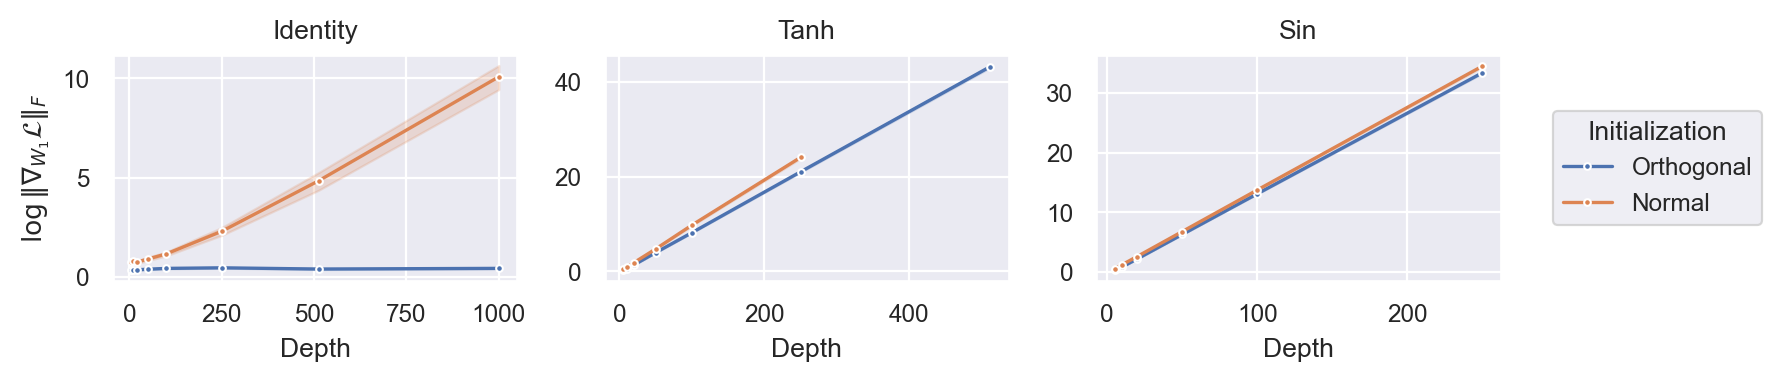

In [14]:
edited_df = df.replace({
    'Initialization': {'orthogonal': 'Orthogonal', 'xavier_normal': 'Normal'}
})

# List of activation functions to plot
activations = ['identity', 'tanh', 'sin']

# Set the plotting style
sns.set_style('darkgrid')  # Assuming 'style' is defined and valid

# Create subplots for each activation function, aligned horizontally
fig, axs = plt.subplots(1, len(activations), dpi=200, figsize=(3 * len(activations), 2))

# Ensure axs is iterable, even with a single subplot
if len(activations) == 1:
    axs = [axs]

for i, (ax, activation) in enumerate(zip(axs, activations)):
    # Filter data for the current activation function
    act_df = edited_df[edited_df['Activation'] == activation]

    # Plot the gradient norm across depths for the current activation function
    # Set legend to 'full' for the last subplot, and False for others
    sns.lineplot(data=act_df, x='Depth', y='grad', hue='Initialization', ax=ax, legend='full' if i == len(activations) - 1 else False, marker='.')
    
    # Set the y-axis label and the plot title
    ax.set_ylabel(r'$\log \| \nabla_{W_1} \mathcal{L} \|_F$' if ax is axs[0] else '')
    ax.set_title(f'{activation.capitalize()}')
    
    if i == len(activations) - 1: sns.move_legend(ax, "center left", bbox_to_anchor=(1.1, 0.5))

    

# Adjust layout to avoid overlap and ensure everything fits nicely
fig.tight_layout()

plt.savefig(figure_dir+'weight_init.pdf')

# Show the figure
plt.show()


# 3 - Gain effect

In [15]:
# Possible choices : ['MNIST', 'CIFAR10', 'CIFAR100', 'FashionMNIST']
DATASET = 'CIFAR10'

In [16]:
d = 100 # MLP WIDTH (HIDDEN LAYER SIZE)
n = 100 # BATCH SIZE

# Load dataset
root_dir = 'Data/'
train_set = getattr(datasets, DATASET)(root=root_dir, train=True, download=True, transform=DS_TRANSFORMS[DATASET])
train_loader = torch.utils.data.DataLoader(train_set, batch_size=n, shuffle=True)

# Prepare test data
test_x, test_y = next(iter(train_loader))
test_x = test_x.to(device).flatten(1, -1)
test_y = test_y.to(device)

Files already downloaded and verified


In [17]:
# Experiment configurations
inits = ['orthogonal']
act_names = ['identity', 'sin', 'tanh']
depths = [5, 10, 20, 50, 100, 200, 500, 1000]
exponents = [0.0, -0.4]

# Generate all combinations of configurations
runs = list(itertools.product(inits, act_names, depths, exponents))


In [18]:
# DataFrame to collect results
df = []

# Run experiments
for init_type, act_name, depth, exponent in tqdm(runs, desc="Running experiments"):

    
    for _ in range(10):  # Repeat experiment 10 times for more stable results
        # Initialize model with given configuration
        activation = ACTIVATIONS[act_name]
        model = MLPWithBatchNorm(
            input_dim=DS_INPUT_SIZES[DATASET], 
            output_dim=DS_NUM_CLASSES[DATASET], 
            num_layers=depth, 
            hidden_dim=d, 
            norm_type='torch_bn',
            mean_reduction=False,
            activation=activation,
            exponent=exponent,
            bias=True,
            order='norm_act',
            save_hidden=True
        ).to(device)
        
        # Reset parameters based on initialization type
        model.reset_parameters(init_type, gain=GAINS[act_name])
        
        # Perform forward pass and compute loss
        criterion = nn.CrossEntropyLoss()
        y_pred = model(test_x)
        loss = criterion(y_pred, test_y)
        
        # Backpropagate to compute gradients
        model.zero_grad()
        loss.backward()
        
        # Collect data
        df.append({
            'grad': model.layers['fc_1'].weight.grad.norm().log().item(),
            'Activation': act_name,
            'Initialization': init_type,
            'Exponent': exponent,
            'Depth': depth
        })

# Convert results to DataFrame
df = pd.DataFrame(df)

Running experiments: 100%|██████████| 48/48 [01:58<00:00,  2.46s/it]


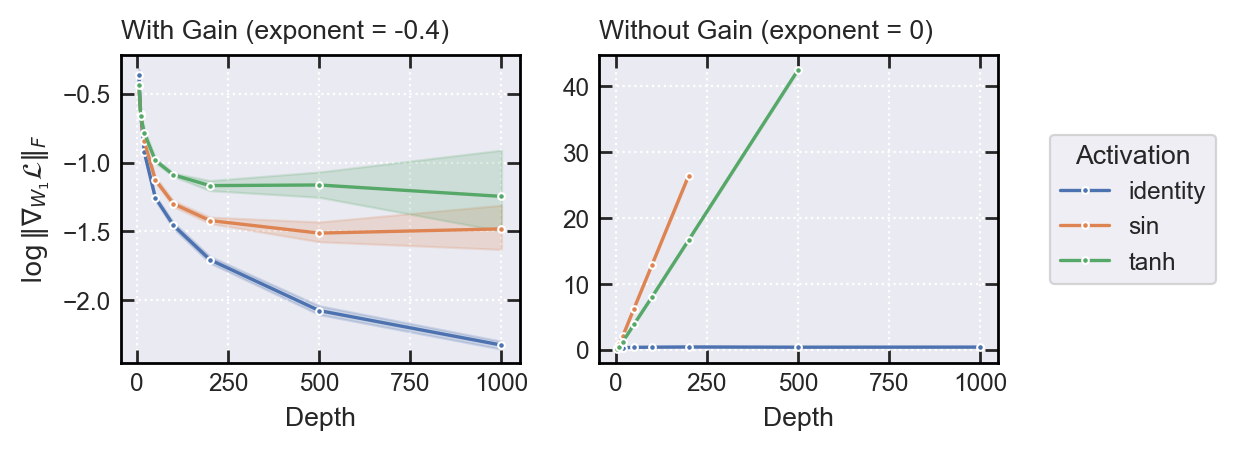

In [19]:
sns.set_style('darkgrid', style)

# Determine the unique exponents to create a subplot for each
unique_exponents = sorted(df['Exponent'].unique())

# Create subplots dynamically based on the number of unique exponents
fig, axs = plt.subplots(dpi=200, ncols=len(unique_exponents), figsize=(6.5, 1 * len(unique_exponents)))

# Ensure axs is iterable even for a single subplot
axs = axs.flatten() if len(unique_exponents) > 1 else [axs]

for ax, exponent in zip(axs, unique_exponents):
    sns.lineplot(data=df[df['Exponent'] == exponent], x='Depth', y='grad', legend='full' if ax is axs[-1] else False, hue='Activation', marker='.', ax=ax)
    title = 'Without Gain (exponent = 0)' if exponent == 0 else f'With Gain (exponent = {exponent})'
    ax.set_title(title, loc='left')
    ax.set_ylabel(r'$\log \| \nabla_{W_1} \mathcal{L} \|_F$' if ax is axs[0] else '')
    ax.set_xlabel('Depth')
    if ax is axs[-1]: sns.move_legend(ax, "center left", bbox_to_anchor=(1.1, 0.5))


# Place a single, non-overlapping legend outside the last subplot
fig.subplots_adjust(right=0.8)  # Adjust subplot params to give some space for legend


plt.savefig(figure_dir+'gain.pdf')

# Display the figure
plt.show()


# 4 - Effect of exponent on Gain

In [20]:
# Possible choices : ['MNIST', 'CIFAR10', 'CIFAR100', 'FashionMNIST']
DATASET = 'CIFAR10'

In [21]:
d = 100 # MLP WIDTH (HIDDEN LAYER SIZE)
n = 100 # BATCH SIZE

# Load dataset
root_dir = 'Data/'
train_set = getattr(datasets, DATASET)(root=root_dir, train=True, download=True, transform=DS_TRANSFORMS[DATASET])
train_loader = torch.utils.data.DataLoader(train_set, batch_size=n, shuffle=True)

# Prepare test data
test_x, test_y = next(iter(train_loader))
test_x = test_x.to(device).flatten(1, -1)
test_y = test_y.to(device)

Files already downloaded and verified


In [22]:
# New experiment configurations
inits = ['orthogonal']  # Only one initialization method
act_names = ['tanh', 'sin']  # Focusing on 'tanh' and 'sin' activations
depths = [50, 100, 150, 200]  # Specified depths
exponents = [-1, -0.8, -0.6, -0.4, -0.2, 0]  # Specified exponent values

# Generate all combinations of configurations
runs = list(itertools.product(inits, act_names, depths, exponents))

# DataFrame to collect results
df = []

# Run experiments
for init_type, act_name, depth, exponent in tqdm(runs, desc="Running experiments"):
    for _ in range(10):  # Repeat experiment 10 times for more stable results
        activation = ACTIVATIONS[act_name]
        model = MLPWithBatchNorm(
            input_dim=DS_INPUT_SIZES[DATASET], 
            output_dim=DS_NUM_CLASSES[DATASET], 
            num_layers=depth, 
            hidden_dim=d,  # Assuming 'd' is defined elsewhere
            norm_type='torch_bn',
            mean_reduction=False,
            activation=activation,
            exponent=exponent,
            bias=True,
            order='norm_act',
            save_hidden=True
        ).to(device)
        
        model.reset_parameters(init_type, gain=GAINS[act_name])
        
        criterion = nn.CrossEntropyLoss()
        y_pred = model(test_x)
        loss = criterion(y_pred, test_y)
        
        model.zero_grad()
        loss.backward()
        
        df.append({
            'grad': model.layers['fc_1'].weight.grad.norm().log().item(),
            'Activation': act_name,
            'Depth': depth,
            'Exponent': exponent
        })

# Convert results to DataFrame
df = pd.DataFrame(df)


Running experiments: 100%|██████████| 48/48 [01:02<00:00,  1.31s/it]


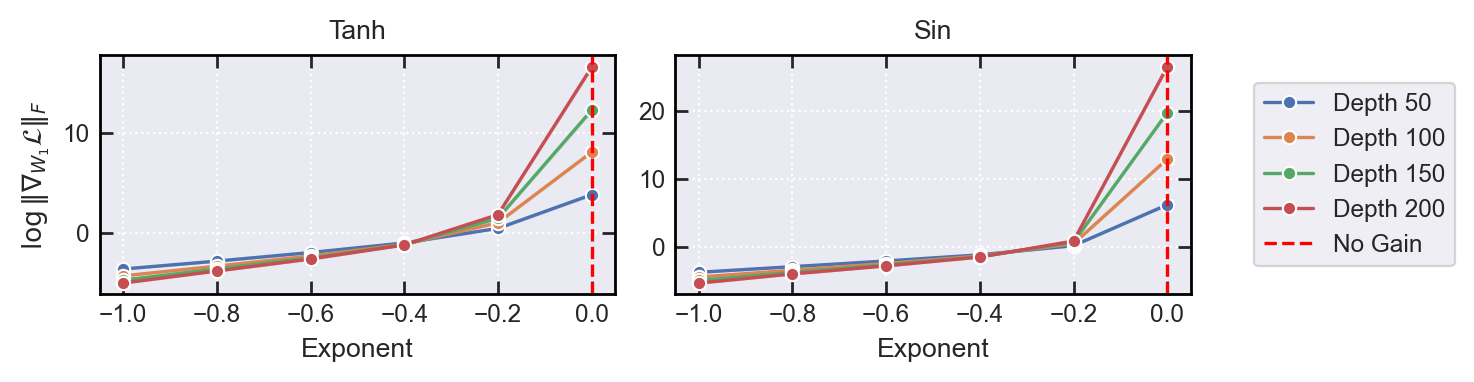

In [23]:
# Set plotting style
sns.set_style('darkgrid', style)

# Filter DataFrame for tanh and sin activations only
filtered_df = df[df['Activation'].isin(['tanh', 'sin'])]

# Determine unique activations and depths for plotting
unique_activations = filtered_df['Activation'].unique()
unique_depths = sorted(filtered_df['Depth'].unique())

# Create subplots for each activation
fig, axs = plt.subplots(1, len(unique_activations), figsize=(4 * len(unique_activations), 2), dpi=200)

# Ensure axs is iterable when there is only one subplot
if len(unique_activations) == 1:
    axs = [axs]

for ax, activation in zip(axs, unique_activations):
    # Plot for each depth within the activation
    for depth in unique_depths:
        depth_df = filtered_df[(filtered_df['Activation'] == activation) & (filtered_df['Depth'] == depth)]
        sns.lineplot(data=depth_df, x='Exponent', y='grad', label=f'Depth {depth}', ax=ax, marker='o')
    
    ax.set_title(f'{activation.capitalize()}')
    ax.set_xlabel('Exponent')
    if ax is axs[0] : ax.set_ylabel(r'$\log \| \nabla_{W_1} \mathcal{L} \|_F$')
    else: ax.set_ylabel('')
    
    # Add a vertical red dashed line at exponent = 0 to indicate "No Gain"
    ax.axvline(x=0, color='red', linestyle='--', label='No Gain')
    
    # Only show the legend for the 'sin' activation figure and move it outside
    if activation == 'sin':
        ax.legend(bbox_to_anchor=(1.1, 0.5), loc='center left')
    else:
        ax.legend([],[], frameon=False)  # Empty legend for non-sin activations

# Adjust layout and legend
plt.tight_layout()
plt.subplots_adjust(right=0.75)  # Adjust right parameter to fit the legend for the 'sin' figure

plt.savefig(figure_dir+'exponent_effect.pdf')

# Display the figure
plt.show()
